In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from utils.visualization import load_results
from utils.model import SimpleCNN, MLP


{'dataset': 'Cifar10', 'model': 'simple_cnn', 'batch_size': 64, 'epochs': 100, 'optimizer': 'sgd', 'lr': 0.001, 'momentum': 0.9, 'u': 0.01, 'load_model': 'None', 'input_shape': [3, 32, 32], 'num_classes': 10}


<Axes: xlabel='epoch'>

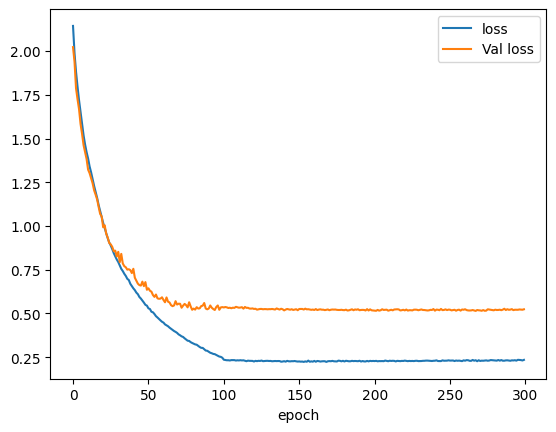

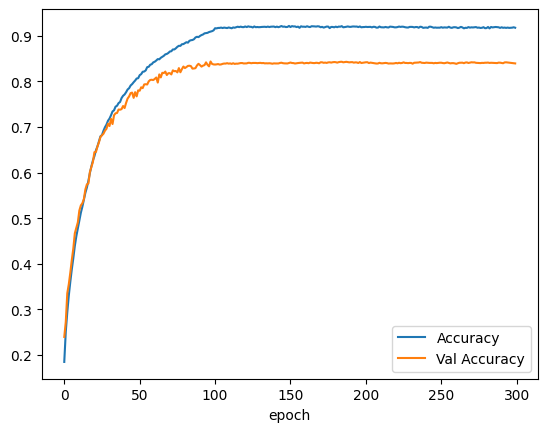

In [2]:
config, results = load_results("results/Cifar10_simple_cnn_sgd_42_append_64.yaml")
print(config)
model_zo = SimpleCNN(config["input_shape"], config["num_classes"])
model_zo.load_state_dict(torch.load("results/Cifar10_simple_cnn_sgd_42_append_64.pt"))

results.plot(x="epoch", y=["loss", "Val loss"])
results.plot(x="epoch", y=["Accuracy", "Val Accuracy"])

<Axes: xlabel='epoch'>

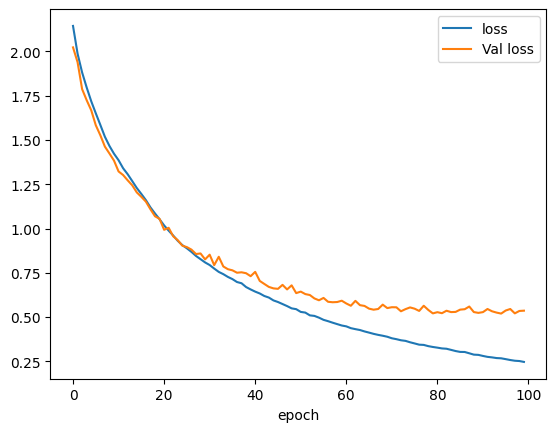

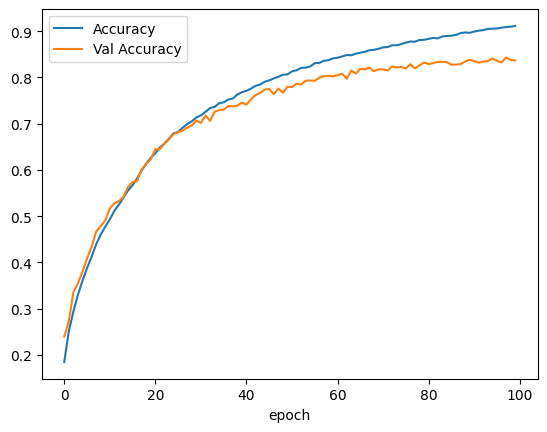

In [3]:
config, results = load_results("results/Cifar10_simple_cnn_sgd_42.yaml")
model_sgd = SimpleCNN(config["input_shape"], config["num_classes"])
model_sgd.load_state_dict(torch.load("results/Cifar10_simple_cnn_sgd_42.pt"))

results.plot(x="epoch", y=["loss", "Val loss"])
results.plot(x="epoch", y=["Accuracy", "Val Accuracy"])

In [4]:
from utils.dataset import get_CIFAR

train_data, test_data = get_CIFAR(config)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
@torch.no_grad()
def test_model_noisy_data(model, test_data, metric, sigma=0.1):
    model.eval()
    model.to("cuda")
    metric.reset()
    metric.to("cuda")
    for batch in test_data:
        x, y = batch[0].to("cuda"), batch[1].to("cuda")
        x = x + sigma * torch.randn_like(x)
        y_hat = model(x)
        metric(y_hat, y)
    
    return metric.compute()

def test_model_adversarial(model, test_data, metric, sigma=0.1):
    model.eval()
    model.to("cuda")
    metric.reset()
    metric.to("cuda")
    for batch in test_data:
        x, y = batch[0].to("cuda"), batch[1].to("cuda")
        attack = torch.zeros_like(x, requires_grad=True)
        optimizer = torch.optim.SGD([attack], lr=sigma)
        criterion = torch.nn.CrossEntropyLoss()

        for _ in range(1):
            y_hat = model(x+attack)
            loss = -criterion(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        y_hat = model(x + attack)
        metric(y_hat, y)
    
    return metric.compute()

In [6]:
from tqdm import tqdm
# sigmas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sigmas = [0, 1, 5, 10, 20, 30, 50, 100]
zo_accs = []
sgd_accs = []
for sigma in tqdm(sigmas):
    zo_accs.append(test_model_adversarial(model_zo, test_data, Accuracy(task="multiclass", num_classes=10), sigma=sigma))
    sgd_accs.append(test_model_adversarial(model_sgd, test_data, Accuracy(task="multiclass", num_classes=10), sigma=sigma))
    # zo_accs.append(test_model_noisy_data(model_zo, test_data, Accuracy(task="multiclass", num_classes=10), sigma=sigma))
    # sgd_accs.append(test_model_noisy_data(model_sgd, test_data, Accuracy(task="multiclass", num_classes=10), sigma=sigma))

100%|██████████| 8/8 [00:36<00:00,  4.54s/it]


[0.8391 0.838  0.8336 0.8277 0.8192 0.8109 0.7991 0.7739]
[0.8369 0.8359 0.8308 0.8249 0.8152 0.8084 0.7956 0.7699]


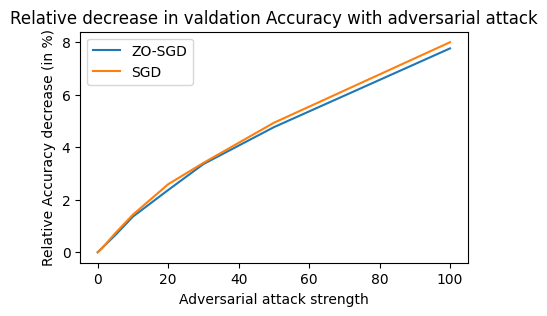

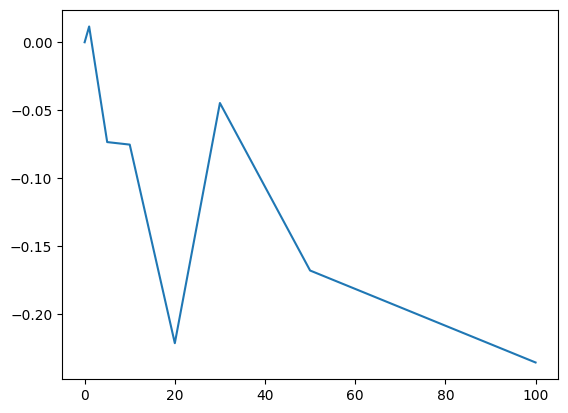

In [7]:
zo_accs = np.array([e.detach().cpu().numpy() for e in zo_accs])
sgd_accs = np.array([e.detach().cpu().numpy() for e in sgd_accs])
print(zo_accs)
print(sgd_accs)

plt.figure(figsize=(5, 3))
zo_relative = (zo_accs-zo_accs[0])/zo_accs[0] * -100
sgd_relative = (sgd_accs-sgd_accs[0])/sgd_accs[0] * -100
plt.plot(sigmas, zo_relative, label="ZO-SGD")
plt.plot(sigmas, sgd_relative, label="SGD")
plt.title("Relative decrease in valdation Accuracy with adversarial attack")
plt.xlabel("Adversarial attack strength")
plt.ylabel("Relative Accuracy decrease (in %)")
plt.legend()
plt.savefig("Adversarial attack CNN", dpi=300, bbox_inches="tight")
plt.show()

plt.plot(sigmas, zo_relative - sgd_relative)
plt.show()